## Entropy curves before and after calibration

Motivating example: Ovid's Unicorn passage:

'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.'

In [1]:
import os
import sys
sys.path.append('../examples')
sys.path.append('../jobs')

from tqdm import trange

import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config

from generate_with_calibration import get_lookahead_entropies

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


Text(0.5, 1.0, 'Entropy blowup, no calibration')

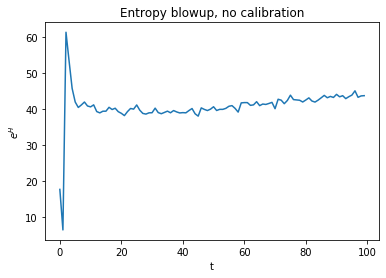

In [26]:
# unicorn text

data = np.load('../jobs/output/113019_entropy/result.npz')['avg_ents'][0]
plt.plot(np.exp(data))
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.title('Entropy blowup, no calibration')

Text(0.5, 1.0, 'Entropy blowup, no calibration, post 20 generations')

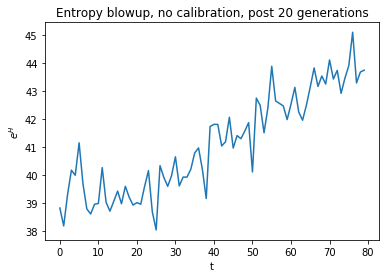

In [27]:
plt.plot(np.exp(data[20:]))
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.title('Entropy blowup, no calibration, post 20 generations')

Text(0.5, 1.0, 'Entropy blowup, top 40 truncation')

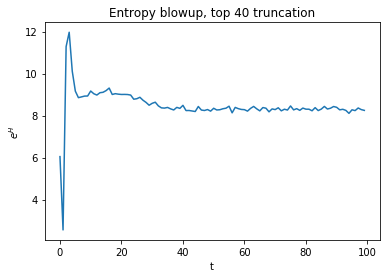

In [28]:
# unicorn text, top 40

data_top40 = np.load('../jobs/output/113019_entropy_top40/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_top40))
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.title('Entropy blowup, top 40 truncation')

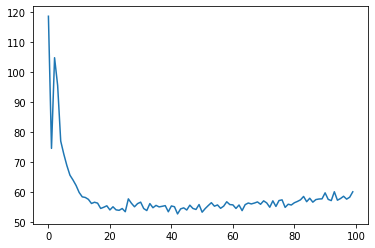

In [12]:
# to be or not to be
data_ctrl = np.load('../jobs/output/113019_entropy_ctrl/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_ctrl))

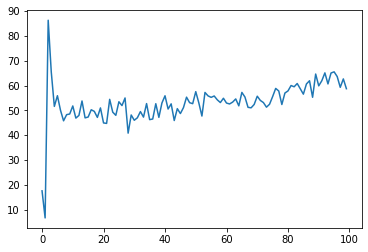

In [115]:
# calibrated on unicorn, avg_ents back down
data_128 = np.load('../jobs/output/120119_cal_top128/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_128))

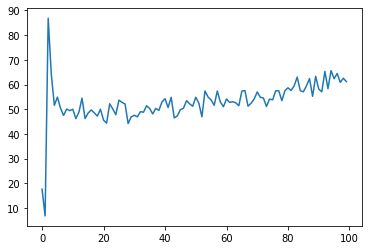

In [3]:
# full calibration
data_full = np.load('../jobs/output/120119_cal_top128/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_full))

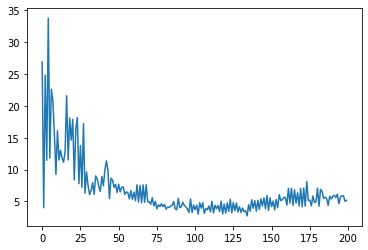

In [103]:
# calibrated on unicorn, avg_ents back down
data_128l = np.load('../jobs/output/113019_cal_128long/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_128l))

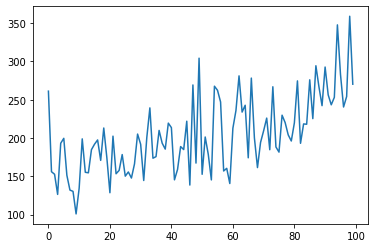

In [116]:
# calibrated on unicorn, top 1024
data_1024 = np.load('../jobs/output/120119_cal_top1024/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_1024))

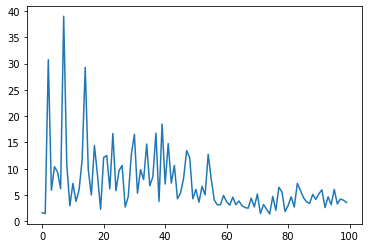

In [4]:
# full calibration
data_cal = np.load('../jobs/output/120119_calibration/result.npz')['avg_ents'][0]
plt.plot(np.exp(data_cal))

Text(0.5, 1.0, 'How calibration affects entropy blowup')

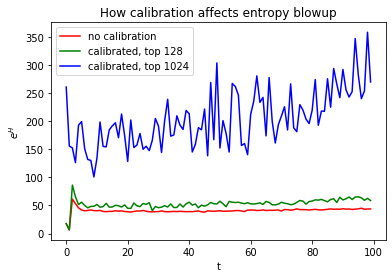

In [117]:
fig, ax = plt.subplots()
ax.plot(np.exp(data), c='red', label='no calibration')
ax.plot(np.exp(data_128), c='green', label='calibrated, top 128')
ax.plot(np.exp(data_1024), c='blue', label='calibrated, top 1024')
ax.set_xlabel('t')
ax.set_ylabel('$e^H$')
ax.legend()
ax.set_title('How calibration affects entropy blowup')

Text(0.5, 1.0, 'How calibration affects entropy blowup')

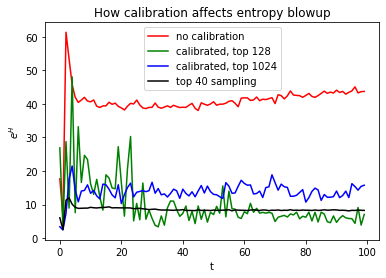

In [35]:
fig, ax = plt.subplots()
ax.plot(np.exp(data), c='red', label='no calibration')
ax.plot(np.exp(data_128), c='green', label='calibrated, top 128')
ax.plot(np.exp(data_1024), c='blue', label='calibrated, top 1024')
ax.plot(np.exp(data_top40), c='black', label='top 40 sampling')
ax.set_xlabel('t')
ax.set_ylabel('$e^H$')
ax.legend()
ax.set_title('How calibration affects entropy blowup')

## Visualizing calibration


In [2]:
def set_seed(seed=42, n_gpu=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()

set_seed()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)
model.eval()

MAX_LENGTH = int(10000)
length = 100

if length < 0 and model.config.max_position_embeddings > 0:
    length = model.config.max_position_embeddings
elif 0 < model.config.max_position_embeddings < length:
    length = model.config.max_position_embeddings  # No generation bigger than model size 
elif length < 0:
    length = MAX_LENGTH 

vocab_size = tokenizer.vocab_size

raw_text = 'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.'
# raw_text = 'I like.'

context = tokenizer.encode(raw_text)

01/04/2020 23:26:30 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json from cache at /u/myhu/.cache/torch/transformers/f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
01/04/2020 23:26:30 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt from cache at /u/myhu/.cache/torch/transformers/d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
01/04/2020 23:26:30 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /u/myhu/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.085d5f6a8e7812ea05ff0e6ed0645ab2e75d80387ad55c1ad9806ee70d272f80
01/04/2020 2

RuntimeError: CUDA error: out of memory

In [ ]:
context = torch.tensor(context, dtype=torch.long, device=device)
context = context.unsqueeze(0)
generated = context

with torch.no_grad():
    inputs = {'input_ids': generated}
    outputs = model(**inputs)
    next_token_logits = outputs[0][:, -1, :]

In [ ]:
next_probs = F.softmax(next_token_logits, dim=-1)
prob = next_probs.mean(axis=0).cpu().numpy()

sort_prob = np.sort(prob)[::-1]
plt.plot(sort_prob[:10])

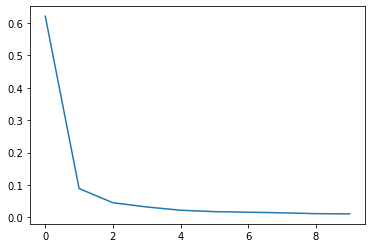

In [6]:
# top k=40 filtering
filter_value=-float('Inf')
indices_to_remove = next_token_logits < torch.topk(next_token_logits, 40)[0][..., -1, None]
next_token_logits[indices_to_remove] = filter_value

next_probs = F.softmax(next_token_logits, dim=-1)
prob = next_probs.mean(axis=0).cpu().numpy()

sort_prob_40 = np.sort(prob)[::-1]
plt.plot(sort_prob_40[:10])

In [7]:
# calibration

lookahead_ents = get_lookahead_entropies(model, generated[0], 64, vocab_size, candidates=None, device=device).unsqueeze(0)
calibrated_next_logits = next_token_logits + (-1.27) * lookahead_ents

next_probs = F.softmax(calibrated_next_logits, dim=-1)
prob = next_probs.mean(axis=0).cpu().numpy()

sort_prob_cal = np.sort(prob)[::-1]
plt.plot(sort_prob_cal[:10])

KeyboardInterrupt: 

In [ ]:
plt.plot(prob)
plt.plot(lookahead_ents.cpu().numpy()[0])

In [ ]:
teddy = lookahead_ents.cpu().numpy()

In [ ]:
fig, ax = plt.subplots()
ax.plot(sort_prob[:10], c='blue', label='uncalibrated')
ax.plot(sort_prob_cal[:10], c='orange', label='calibrated')
ax.set_xlabel('token')
ax.set_ylabel('$p$')
ax.legend()
ax.set_title('Effect of calibration')

In [ ]:
fig, ax = plt.subplots()
ax.bar(range(len(sort_prob[:10])), teddy[0][:10])

In [ ]:
sort_prob[:128].sum()

In [4]:
plt.bar(range(50), sort_prob[:50])
plt.xlabel('token number')
plt.ylabel('$p$')

NameError: name 'sort_prob' is not defined